<a href="https://colab.research.google.com/github/1sumhowdy/face-detection/blob/main/%EC%96%BC%EA%B5%B4%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 얼굴인식
1차: 2021.07.14


In [ ]:
# 주석 (코드 돌아가지 않는 부분)

import numpy as np  #코드

# 할 일 정리
0. 필요한 라이브러리를 가져온다 (import)   
tensorflow, keras, 등등...   
imgshow, numpy, ....

1. colab 에 데이터 불러오기   

2. 모델을 만든다 (CNN 코드를 참고해서)

3. face-training-set 으로 모델을 학습시킨다. (train)
문제랑 정답을 같이 줘서 모델을 트레ㅇ닝

4. 모델이 내놓은 정답이랑, 실제 정답 비교

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib  #시각화ㅡ 그래프 그리기
%matplotlib inline
import matplotlib.pyplot as plt  #plt.img_show()
import os
import cv2
from os.path import isfile, join
import glob
import gzip
from PIL import Image
from scipy import misc

In [3]:
# 딥러닝에 필요한 라이브러리들 import

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [4]:

# CNN
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.utils.np_utils import to_categorical

from keras import layers, regularizers, optimizers, callbacks
from collections import defaultdict
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float

from keras import layers
from keras import models
from keras.utils import np_utils  # to_categorical

<Figure size 432x288 with 0 Axes>

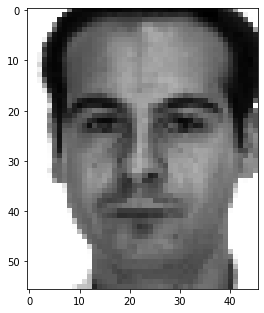

In [5]:
### 첫번째 데이터 출력해보기
img1 = matplotlib.image.imread(join('/content/drive/MyDrive/face-training-set/0001_0001.BMP'))
plt.figure()
plt.figure(figsize=(24,25))
plt.subplot(1,5,1, facecolor='w')
plt.imshow(img1, cmap='gray')

# 꼭 알아야할 개념
### 1. 하이퍼 파라미터 (hyper-parameter)
epochs=40, batch_size=16, learning-rate=0.0001, ...   
활성화 함수(activation func): relu, softmax 등등의 다양한 활성화 함수 존재

### 2. CNN 모델의 layer
-> 성능에 많은 영향

### 3. 트레이닝셋과 테스트셋
트레이닝셋은? 질문과 정답을 같이 준다   
테스트셋은? 질문만 주고, 정답과 비교 -> 성능 측정

### 4. 성능 개선

# 1. 데이터셋 불러오기
트레이닝, 테스트셋 불러오기

In [ ]:

# 학습 결과 분석을 위한 그래프 구현

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # 학습 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # 검증 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

In [6]:
def create_Trainset(folder):
   
    img_data_array=[]
    class_name=[]
    
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = load_img(image_path, 'rb')
        image = img_to_array(image)
        
        if image.shape[2] == 3:
            image = image.mean(2)

        img_data_array.append(image)
        name_index = file.split("_") // [0001. 0001] [0001. 0002]
        name_index = int(name_index[0])
        class_name.append(name_index)
        
    return np.array(img_data_array), np.array(class_name)


def create_Testset(folder):
   
    img_data_array=[]
    class_name=[]
    
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = load_img(image_path, 'rb')
        image = img_to_array(image)
        
        if image.shape[2] == 3:
            image = image.mean(2)

        img_data_array.append(image)
        name_index = file.split(".")
        name_index = int(name_index[0])
        class_name.append(name_index)
        
    return np.array(img_data_array), np.array(class_name)

# 정규화
def normalization(image):  
    image = image / image.max()
    return image


In [7]:
train_PATH = '/content/drive/MyDrive/face-training-set'
x_train, y_train = create_Trainset(train_PATH) #불러오기
x_train = normalization(x_train) # 정규화 진행

test_PATH = '/content/drive/MyDrive/face-test-set'
x_test, _ = create_Testset(test_PATH)
x_test = normalization(x_test)


print('Train images :',x_train.shape)
print('Train labels : ', y_train.shape)
print('Test images : ', x_test.shape)


Train images : (1050, 56, 46)
Train labels :  (1050,)
Test images :  (700, 56, 46)


# 2. CNN 모델 만들기
layer 많이 안 쌓고 기본적인 모델로 일단 해보았다.

# 히히
### 1. 첫번째 모델 만듦
드라이브의 케라스 불러와서 실행했당
레이어는 조금 쌓아서 간단하당

In [8]:
import keras

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(56, 46)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(351, activation='softmax')
])

# loss 함수로 sparse_categorical_crossentropy 사용
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()   # 모델 확인하기


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2576)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               659712    
_________________________________________________________________
dense_1 (Dense)              (None, 351)               90207     
Total params: 749,919
Trainable params: 749,919
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(x_train, y_train, epochs=30)

Epoch 1/30
33/33 [==============================] - 15s 3ms/step - loss: 6.0857 - accuracy: 0.0054
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 5.7702 - accuracy: 0.0046
Epoch 3/30
33/33 [==============================] - 0s 3ms/step - loss: 5.5319 - accuracy: 0.0109
Epoch 4/30
33/33 [==============================] - 0s 3ms/step - loss: 5.1314 - accuracy: 0.0247
Epoch 5/30
33/33 [==============================] - 0s 3ms/step - loss: 4.5952 - accuracy: 0.0622
Epoch 6/30
33/33 [==============================] - 0s 3ms/step - loss: 4.1834 - accuracy: 0.1243
Epoch 7/30
33/33 [==============================] - 0s 3ms/step - loss: 3.7003 - accuracy: 0.2062
Epoch 8/30
33/33 [==============================] - 0s 3ms/step - loss: 3.2416 - accuracy: 0.2785
Epoch 9/30
33/33 [==============================] - 0s 3ms/step - loss: 2.8852 - accuracy: 0.4050
Epoch 10/30
33/33 [==============================] - 0s 3ms/step - loss: 2.5907 - accuracy: 0.4503
Epoch 11/30
33/33 

In [11]:
x_predict = model.predict(x_train)
y_predict = []

print(x_predict.shape)

for image in x_predict:
    y_predict.append(np.argmax(image))

y_predict = np.array(y_predict)


(1050, 351)


In [12]:

def accuracy(original, x_predict):
    accuracy = original == x_predict
    accuracy = np.count_nonzero(accuracy)
    
    return accuracy / original.shape[0]

In [13]:

accuracy(y_train, y_predict)  #모델의 정확도 출력

0.9552380952380952

In [14]:
# test
predictions = model.predict(x_test)  #test데이터의 Y-test 예측하기
print(predictions.shape)

y_test = []
for image in predictions:
    y_test.append(np.argmax(image))

y_test = np.array(y_test)

#결과
print(y_test)


(700, 351)
[118 319 137 221  51 153 132 326 309 212 215 224 212 177 227 345 221 239
 271 180 225 216 158 263 269 284 251 334  55 324 266  34 287 194 280 188
 248  34  34 319  34 177 279 241 342 283 186 125 155 164 229 238 238 118
 128 162 168 303 291 238 279 347 218 213 192 101 226 154 202  98 225 240
 314 181 126 290 220 275 294 115 224 101 236  77  91 199 160  90  61 239
 187  87 188 137 254 144 308 118  93 226 116 167 238 169 288 229 314 238
 196   3 334 146 155 270  92 320  30 218 334 276 203 205 217 151  77 345
 334 257 172 220 279 262 267 313  93 165 178 187 248 128  34 323 340 212
  88 234 235 201 345  85 118 221 235 212 213 236 317 264 316 334 334 328
 213  39  77 229  85 162 191 202 101 183  97  47 278 192 314 334 168 276
 218  86 225 226 243 155 155 263 334 239 312 285  38 296 229 187 215 257
 104 324 165  76 253 223 190 334 305 239 221 239  64 157 229 284 248 193
  92 283 151 220  93 271 161 280  77 213 343 345 218 312 194 185 252 235
 175 250 334 221  34 327 168 239 334 122

In [ ]:

### csv 저장

test_result_df = pd.DataFrame([x for x in zip(test_index, y_test)], columns=['Image', 'Answer'])
test_result_df.head()

test_result_df = test_result_df.sort_values(by="Image")
test_result_df.head()

test_result_df.to_csv("/content/drive/MyDrive/hw2-1-result.csv", index=False)